# Image Based Point Cloud Segmentation

Kefeng Huang timkhuang@icloud.com

## Packages

In [1]:
import os
import torch
import pykitti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from predict import predit_on_label
from utils import get_poses, get_labels
from evaluate import evaluate_sequence
from deepwv3plus_net import DeepWV3Plus, img_transform
from kitti_labels import city2kitti_translate, kitti_colorize

## Resources

This project is using the *Kitti Odometry* dataset for point cloud, images and 
calibration data and *SemanticKitti* for corresponding labels.

* *Kitti Odometry*: http://www.cvlibs.net/datasets/kitti/eval_odometry.php
* *SemanticKitti*: http://www.semantic-kitti.org/

DeepWV3Plus network is used to generate the image label or the image feature.
The code was adapted from NVIDIA/Semantic-Segmentation.
Pre-trained model for kitti downloaded from NVIDIA is also used.
* *NVIDIA/Semantic-Segmentation*: https://github.com/NVIDIA/semantic-segmentation/tree/sdcnet
* *kitti_best.pth*: https://drive.google.com/file/d/1OrTcqH_I3PHFiMlTTZJgBy8l_pladwtg/view?usp=sharing

In [2]:
## DATASET SETTINGS
seq = '06'
kitti_dataset_path = r'../kitti-dataset'
snapshot = r'./kitti_best.pth'

## LOAD DATASET
kitti_dataset = pykitti.odometry(kitti_dataset_path, sequence=seq)

## Segmentation based on Image Predicted Labels

The first part is directly using the labels predicted with 
*NVIDIA/Semantic-Segmentation* method using pre-trained *DeepWV3Plus* network
model *kitti_best.pth*. 

This part also tests different number of images to use and evaluates the 
different using the code adapted from *semanticKitti-api*. 

In [4]:
# Load Pretrained weights to the network
net = DeepWV3Plus()
net = torch.nn.DataParallel(net).cuda()
print('Net Built')

loaded_dict = torch.load(snapshot, map_location=torch.device('cpu'))
net.load_state_dict(loaded_dict['state_dict'])
net.eval()
print('Net restored')


Net Built
Net restored


(370, 1226)


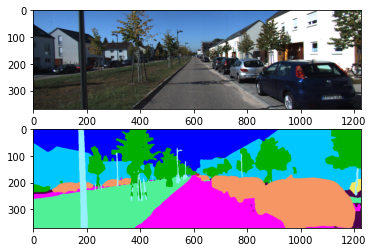

In [23]:
# Generate Random Image
sample_index = np.random.randint(len(kitti_dataset))
sample_img = kitti_dataset.get_cam2(sample_index)

# Generate Predictions
with torch.no_grad():
    img_tensor = img_transform(sample_img)
    pred = net(img_tensor.unsqueeze(0).cuda())
    pred = pred.cpu().numpy().squeeze()
    pred = np.argmax(pred, axis=0)

colored_pred = kitti_colorize(city2kitti_translate(pred))

# Draw the images
fig, axs = plt.subplots(2)
axs[0].imshow(sample_img)
axs[1].imshow(colored_pred)

In [6]:
velo_label_path = f'../kitti-dataset/sequences/{seq}/labels'

labels = []
for l in sorted(os.listdir(velo_label_path)):
    label = np.fromfile(os.path.join(velo_label_path, l), dtype=np.int32)
    labels.append(label)

print(len(labels))

1101


In [7]:
num_prev = 3

predictions = []

for idx, point in enumerate(kitti_dataset.velo):
    predictions.append(predit_on_label(
        point,
        image_label[idx],
        kitti_dataset.poses[idx],
        get_labels(image_label, max(0, idx - num_prev), idx),
        get_poses(kitti_dataset, max(0, idx - num_prev), idx),
        kitti_dataset.calib
    ))

    if idx % 100 == 0:
        print(f'{idx} images predictions has completed')

mean_ap = evaluate_sequence(predictions, labels)
print(f'Mean Average Precision: {mean_ap:2f}')

0 images predictions has completed
100 images predictions has completed
200 images predictions has completed
300 images predictions has completed
400 images predictions has completed
500 images predictions has completed
600 images predictions has completed
700 images predictions has completed
800 images predictions has completed
900 images predictions has completed
1000 images predictions has completed
1100 images predictions has completed
Mean Average Precision: 0.740447


In [8]:
num_prev = 5

predictions = []

for idx, point in enumerate(kitti_dataset.velo):
    predictions.append(predit_on_label(
        point,
        image_label[idx],
        kitti_dataset.poses[idx],
        get_labels(image_label, max(0, idx - num_prev), idx),
        get_poses(kitti_dataset, max(0, idx - num_prev), idx),
        kitti_dataset.calib
    ))

    if idx % 100 == 0:
        print(f'{idx} images predictions has completed')

mean_ap = evaluate_sequence(predictions, labels)
print(f'Mean Average Precision: {mean_ap:2f}')

0 images predictions has completed
100 images predictions has completed
200 images predictions has completed
300 images predictions has completed
400 images predictions has completed
500 images predictions has completed
600 images predictions has completed
700 images predictions has completed
800 images predictions has completed
900 images predictions has completed
1000 images predictions has completed
1100 images predictions has completed
Mean Average Precision: 0.731010


In [9]:
num_prev = 7

predictions = []

for idx, point in enumerate(kitti_dataset.velo):
    predictions.append(predit_on_label(
        point,
        image_label[idx],
        kitti_dataset.poses[idx],
        get_labels(image_label, max(0, idx - num_prev), idx),
        get_poses(kitti_dataset, max(0, idx - num_prev), idx),
        kitti_dataset.calib
    ))

    if idx % 100 == 0:
        print(f'{idx} images predictions has completed')

mean_ap = evaluate_sequence(predictions, labels)
print(f'Mean Average Precision: {mean_ap:2f}')

0 images predictions has completed
100 images predictions has completed
200 images predictions has completed
300 images predictions has completed
400 images predictions has completed
500 images predictions has completed
600 images predictions has completed
700 images predictions has completed
800 images predictions has completed
900 images predictions has completed
1000 images predictions has completed
1100 images predictions has completed
Mean Average Precision: 0.722302


In [10]:
num_prev = 9

predictions = []

for idx, point in enumerate(kitti_dataset.velo):
    predictions.append(predit_on_label(
        point,
        image_label[idx],
        kitti_dataset.poses[idx],
        get_labels(image_label, max(0, idx - num_prev), idx),
        get_poses(kitti_dataset, max(0, idx - num_prev), idx),
        kitti_dataset.calib
    ))

    if idx % 100 == 0:
        print(f'{idx} images predictions has completed')

mean_ap = evaluate_sequence(predictions, labels)
print(f'Mean Average Precision: {mean_ap:2f}')

0 images predictions has completed
100 images predictions has completed
200 images predictions has completed
300 images predictions has completed
400 images predictions has completed
500 images predictions has completed
600 images predictions has completed
700 images predictions has completed
800 images predictions has completed
900 images predictions has completed
1000 images predictions has completed
1100 images predictions has completed
Mean Average Precision: 0.716746


## Segmentation based on Image Features

### Create Dataset

The last layer in the DeepWV3Plus network is deleted in order to extract the
image feature instead of the final labels.
In order to train network based on the features from the image, we create a dataset
using the adapted network. In this dataset, the input value is 256 features and 
the label is the ground truth value of that point in semanticKitti.
The features are averaged from previous 3 frames.  

1. not fixed number of previous images
   1. plan to use 0 for place holder
2. point or image
3. which part to delete?
4. 
